# Methods for Data Science: Course Work 2

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

First process the data. `x_train_MNIST_org` and `x_test_MNIST_org` are original data of predictors. 

In Multi-Layer Perceptron Model, the magnitude of predictors will affect the accuracy, causing problems in minimising loss function. So we need to standardise data of predictor variables. `x_train_MNIST` and `x_test_MNIST` are standardised data of predictors. 

In [2]:
# load MNIST data
MNIST_train = pd.read_csv('MNIST_train.csv')
MNIST_test = pd.read_csv('MNIST_test.csv')

In [3]:
# extract input features and labels
X_train_MNIST_org = MNIST_train.values[:, 1:]
y_train_MNIST = MNIST_train.values[:, 0]

X_test_MNIST_org = MNIST_test.values[:, 1:]
y_test_MNIST = MNIST_test.values[:, 0]

In [4]:
# standardise function
def standardise(X):
    mu = np.mean(X, axis=0) # mean of data X
    std = np.std(X, axis=0) # standard deviation of data X
    std_filled = std.copy()
    std_filled[std == 0] = 1. # replace 0 with a small value to avoid division by zero
    Xbar = ((X - mu) / std_filled) # standardise data
    return Xbar, mu, std_filled

In [5]:
# standardise the inputs
X_train_MNIST, mu_train_MNIST, sigma_train_MNIST = standardise(X_train_MNIST_org)
X_test_MNIST = (X_test_MNIST_org - mu_train_MNIST) / sigma_train_MNIST

In [6]:
# one hot encoding on y
y_train_MNIST_ohe = np.eye(10)[y_train_MNIST]
y_test_MNIST_ohe = np.eye(10)[y_test_MNIST]

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

Implement a multi-layer perceptron with 3 hidden layers (with 200 neurons each), followed by the output layer with 10 neurons (one for each class). Use softplus activation function between all hidden layers and softmax function on the output layer. Use the KL divergence as loss function.

First define the activation functions and loss function.

In [7]:
# define hidden layer activation function
def softplus(x, beta=1):
    return np.log(1 + np.exp(beta * x)) / beta

# define output layer activation function
def softmax(a):
    m, n = np.shape(a)
    y = np.zeros([m, n])
    for i in range(m):
        y[i, :] = np.exp(a[i]) / np.sum(np.exp(a[i]))
    return y

# define pre-activation function
def dense(x, W, b):
    a = b + x @ W
    return a

The loss function $\mathcal{L}$ for data example $(x, y)$ has the form:

$$\mathcal{L} = \sum_{j=1}^{10}\left(y_{\text{true}}\right)_j\cdot\left(\log \left(y_{\text{true}}\right)_j - \log \left(y_{\text{pred}}\right)_j\right)$$

where $y_{\text{true}}$ is the true label of the data point and $y_{\text{pred}}$ is the prediction of the model. 

If we use one-hot encoding for $y_{\text{true}}$, assume the $i$th entry of $y_{\text{true}}$ is 1 and other entries are 0, the loss function can be simplify to $\mathcal{L} = - \log \left(y_{\text{pred}}\right)_i$. The prediction $y_{\text{pred}}$ is the output of the softmax function and $\left(y_{\text{pred}}\right)_i=\sigma_{\text{out}}\left(\mathbf{a}^{(4)}\right)_i=\frac{\exp \left(\mathbf{a}^{(4)}_i\right)}{\sum_j\exp\left(\mathbf{a}^{(4)}_j\right)}$, where $\mathbf{a}^{(4)} = \boldsymbol{W}^{(3)}\boldsymbol{h}^{(3)} + \boldsymbol{b}^{(3)}$.

Use the backpropagation algorithm to calculate the derivative of the loss function. We will start by computing the output error $\boldsymbol{\delta}^{(4)} = \frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{(4)}}$.

The derivative of $\mathcal{L}$ with respect to the pre-activation $\boldsymbol{a}^{(4)}$ in the output layer can be calculated as $\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{(4)}} = \frac{\partial \mathcal{L}}{\partial y_{\text{pred}}} \cdot \frac{\partial y_{\text{pred}}}{\partial \boldsymbol{a}^{(4)}}$ by chain rule. The first term on the left-hand side is $\frac{\partial \mathcal{L}}{\partial y_{\text{pred}}} = - \frac{y_{\text{true}}}{y_{\text{pred}}}$ which is a vector of length 10 with $- \frac{1}{\left(y_{\text{pred}}\right)_i}$ on $i$th entry and 0 otherwise. 

The derivative of the softmax activation function with respect to the pre-activation $\boldsymbol{a}^{(4)}_j$ of the $i$th neuron is a $10\times 10$ matrix: 

$$\frac{\partial \left(y_{\text{pred}}\right)_i}{\partial \boldsymbol{a}^{(4)}_j} = 
\left\{
\begin{aligned}
&\frac{\exp \left(\mathbf{a}^{(4)}_i\right)}{\sum_k\exp\left(\mathbf{a}^{(4)}_k\right)}\left(1 - \frac{\exp \left(\mathbf{a}^{(4)}_i\right)}{\sum_k\exp\left(\mathbf{a}^{(4)}_k\right)}\right) = \left(y_{\text{pred}}\right)_i\left(1 - \left(y_{\text{pred}}\right)_i\right)
\quad \quad \text{if}\quad i = j
\\
&-\frac{\exp \left(\mathbf{a}^{(4)}_j\right)}{\sum_k\exp\left(\mathbf{a}^{(4)}_k\right)}\frac{\exp \left(\mathbf{a}^{(4)}_i\right)}{\sum_k\exp\left(\mathbf{a}^{(4)}_k\right)} =  - \left(y_{\text{pred}}\right)_j\left(y_{\text{pred}}\right)_i
\quad \quad \text{if}\quad i \neq j
\end{aligned}
\right.$$

Substituting the expressions into the chain rule formula, assuming the $i$th entry of $y_{\text{true}}$ is 1, we get (of course $i$ could also be 1 or 10): 

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{(4)}} &= \begin{bmatrix}
0 & \cdots & - \frac{1}{\left(y_{\text{pred}}\right)_i} & \cdots & 0
\end{bmatrix}
\begin{bmatrix}
\left(y_{\text{pred}}\right)_{1}\left(1 - \left(y_{\text{pred}}\right)_{1}\right) & \cdots & - \left(y_{\text{pred}}\right)_{10}\left(y_{\text{pred}}\right)_{1} \\
\vdots & \ddots & \vdots \\
- \left(y_{\text{pred}}\right)_{1}\left(y_{\text{pred}}\right)_{10} & \cdots & \left(y_{\text{pred}}\right)_{10}\left(1 - \left(y_{\text{pred}}\right)_{10}\right) \\
\end{bmatrix}
\\
\\
&=\begin{bmatrix}
\frac{1}{\left(y_{\text{pred}}\right)_i}\left(y_{\text{pred}}\right)_{1}\left(y_{\text{pred}}\right)_{i} & \cdots & - \frac{1}{\left(y_{\text{pred}}\right)_i}\left(y_{\text{pred}}\right)_{i}\left(1 - \left(y_{\text{pred}}\right)_{i}\right) & \cdots & \frac{1}{\left(y_{\text{pred}}\right)_i}\left(y_{\text{pred}}\right)_{10}\left(y_{\text{pred}}\right)_{i}
\end{bmatrix}
\\
\\
&=\begin{bmatrix}
\left(y_{\text{pred}}\right)_{1} & \cdots & \left(y_{\text{pred}}\right)_{i}-1 & \cdots & \left(y_{\text{pred}}\right)_{10}
\end{bmatrix}
\end{aligned}$$

In [8]:
def output_error(y_batch, a4):
    """
    Arguments:
        y_batch: K x 10 array of data outputs using one-hot encoding
        a4: K x 10 array of output pre-activations
    Return:
        K x 10 array of output errors 
    """
    # K is the size of data set
    y_pred = softmax(a4)
    d = []
    for i in range(len(y_batch)):
        di = y_pred[i]
        yi = y_batch[i]
        indi = np.argmax(yi)
        di[indi] -= 1
        d.append(di)
    
    return np.array(d)

We will also need to compute the diagonal matrix $\boldsymbol{\sigma}'(\boldsymbol{a}^{(i)})$ for $i \in \{1,2,3\}$. For softplus function $\boldsymbol{\sigma}\left(\boldsymbol{a}^{(i)}\right) = \log\left(1+\exp\left(\boldsymbol{a}^{(i)}\right)\right)$, the derivative will be $\frac{\partial \boldsymbol{\sigma}\left(\boldsymbol{a}^{(i)}\right)}{\partial \boldsymbol{a}^{(i)}} = \frac{\exp\left(\boldsymbol{a}^{(i)}\right)}{1+\exp\left(\boldsymbol{a}^{(i)}\right)}$.

In [9]:
def activation_derivative(ai):
    """
    Arguments:
        ai: K x 200 array of hidden layer pre-activations
    Return:
        K x 200 array of diagonal elements  
    """
    
    return np.exp(ai) / (1 + np.exp(ai))

Given the error $\boldsymbol{\delta}^{(k+1)}$, kernel matrix $\boldsymbol{W}^{(k)}$ and the preactivations $\boldsymbol a^{(k)}$, we need to backpropagate to get $\boldsymbol{\delta}^{(k)}$ by $\boldsymbol{\delta}^{(k)}_p = \sigma'\left(\boldsymbol{a}_p^{(k)}\right)\sum_{j=1}^{n_{k+1}}\boldsymbol{w}^{(k)}_{jp}\boldsymbol{\delta}^{(k+1)}_j$.

In [10]:
def backpropagate(delta_i_1, W_i, a_i):
    """
    Arguments:
        delta_i_1: array of output errors
        W_i: weight array
        a_i: array of hidden layer pre-activations
    Return:
        K x 200 array of hidden layer errors
    """
    # K here is the minibatch size

    return (delta_i_1 @ W_i.T) * activation_derivative(a_i)

Given the errors $\boldsymbol{\delta}^{(1)}$, $\boldsymbol{\delta}^{(2)}$, $\boldsymbol{\delta}^{(3)}$ and $\boldsymbol{\delta}^{(4)}$ and post-activations, we can compute the gradients $\frac{\partial\mathcal{L}}{\partial \boldsymbol{W}^{(i)}}$, $\frac{\partial\mathcal{L}}{\partial \boldsymbol{b}^{(i)}}$ for $i \in \{0,1,2,3\}$.

The function below should compute these gradients, averaged over the batch size.

In [11]:
def grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3):
    """
    Arguments:
        delta1, delta2, delta3: K x 200 array of hidden layer errors
        delta4: K x 10 array of output errors
        h0: K x 784 array of inputs
        h1, h2, h3: K x 200 array of hidden layer post-activations
    Returns:
        tuple of arrays of shape (784 x 200), (200,), (200 x 200), (200,), (200 x 200), (200,), (200 x 10), (10,) for gradients
    """
    
    grad_W0 = delta1[:, np.newaxis, :] * h0[:, :, np.newaxis] # dimension (K,784,200)
    grad_b0 = delta1 # dimension (K,200)
    grad_W1 = delta2[:, np.newaxis, :] * h1[:, :, np.newaxis] # dimension (K,200,200)
    grad_b1 = delta2 # dimension (K,200)
    grad_W2 = delta3[:, np.newaxis, :] * h2[:, :, np.newaxis] # dimension (K,200,200) 
    grad_b2 = delta3 # dimension (K,200)
    grad_W3 = delta4[:, np.newaxis, :] * h3[:, :, np.newaxis] # dimension (K,200,10)
    grad_b3 = delta4 # dimension (K,10)
    
    grad_W0 = np.mean(grad_W0, axis=0) # dimension (784,200)
    grad_b0 = np.mean(grad_b0, axis=0) # dimension (200)
    grad_W1 = np.mean(grad_W1, axis=0) # dimension (200,200)
    grad_b1 = np.mean(grad_b1, axis=0) # dimension (200)
    grad_W2 = np.mean(grad_W2, axis=0) # dimension (200,200)
    grad_b2 = np.mean(grad_b2, axis=0) # dimension (200)
    grad_W3 = np.mean(grad_W3, axis=0) # dimension (200,10)
    grad_b3 = np.mean(grad_b3, axis=0) # dimension (10)
    
    return grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3

Update parameters using stochastic gradient descent method.

In [12]:
def update_para(x_batch, learning_rate, y_batch, W0, b0, W1, b1, W2, b2, W3, b3):
    """
    Arguments:
        x_batch: K x 784 input data
        y_batch: K x 10 observations
        learning_rate: scalar represent learning rate in SGD process
        W0, W1, W2, W3: weight matrix
        b0, b1, b2, b3: bias array
    Returns:
        W0, W1, W2, W3, b0, b1, b2, b3 update by optimising loss function with stochastic gradient descent
    """
    
    # forward pass
    h0 = x_batch
    a1 = dense(h0, W0, b0)
    h1 = softplus(a1)
    a2 = dense(h1, W1, b1)
    h2 = softplus(a2)
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3)
    a4 = dense(h3, W3, b3)
    
    # calculate derivative of loss function
    delta4 = output_error(y_batch, a4)
    delta3 = backpropagate(delta4, W3, a3)
    delta2 = backpropagate(delta3, W2, a2) 
    delta1 = backpropagate(delta2, W1, a1)
    grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3)
    
    # stochastic gradient descent
    W0 -= learning_rate * grad_W0
    W1 -= learning_rate * grad_W1
    W2 -= learning_rate * grad_W2
    W3 -= learning_rate * grad_W3
    b0 -= learning_rate * grad_b0
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    b3 -= learning_rate * grad_b3
    
    return W0, b0, W1, b1, W2, b2, W3, b3

Use these parameters and `dense` function to create the MLP model. The hidden layers of the model use a `softplus` activation, and the output of the model uses a `softmax` function.

In [13]:
def mlp(x, W0, b0, W1, b1, W2, b2, W3, b3, return_h1 = False):
    """
    Arguments:
        x: K x 784 array of inputs
        W0, W1, W2, W3: weight matrix
        b0, b1, b2, b3: bias array
    Return:
        K x 10 output array
    """
    
    a1 = dense(x, W0, b0)
    h1 = softplus(a1)
    a2 = dense(h1, W1, b1)
    h2 = softplus(a2)
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3)
    a4 = dense(h3, W3, b3)
    y = softmax(a4)
    
    if return_h1:
        return y, h1
    else:
        return y

Define a function to calculate KL divergence as a loss function.

In [14]:
def kl_divergence(y_true, y_pred):
    """
    Arguments:
        y_true: K x 10 observations
        y_pred: K x 10 predicted values
    Return:
        KL divergence loss value
    """
    
    kl = 0
    m, n = np.shape(y_true)
    for i in range(m):
        for j in range(n):
            if y_true[i,j] != 0 and y_pred[i,j] != 0:
                kl += y_true[i,j] * (np.log(y_true[i,j]) - np.log(y_pred[i,j]))
    return kl

Train the network several times, gradually varying the learning rate after each training between $10^{-5}$ and $10^{-1}$. Record the final loss achieved for each learning rate value and plot it as a function of the learning rate.

In [15]:
# initialise parameters
learning_rates = [1e-5, 1e-3, 1e-2, 3e-2, 5e-2, 8e-2, 1e-1]
epochs = 40
batch_size = 128
kl_list = []

In [16]:
for lr in learning_rates:
    
    # initialise the parameters
    var0 = 2. / (200 + 784)
    W0 = np.random.randn(784, 200) * np.sqrt(var0)
    b0 = np.zeros(200)

    var1 = 2. / (200 + 200)
    W1 = np.random.randn(200, 200) * np.sqrt(var1)
    b1 = np.zeros(200)

    var2 = 2. / (200 + 200)
    W2 = np.random.randn(200, 200) * np.sqrt(var2)
    b2 = np.zeros(200)

    var3 = 2. / (10 + 200)
    W3 = np.random.randn(200, 10) * np.sqrt(var3)
    b3 = np.zeros(10)

    # train MLP
    for _ in range(epochs):
        for index in range(0, X_train_MNIST.shape[0], batch_size):
            
            # divide data into batches
            X_train_MNIST_batch = X_train_MNIST[index:min(index + batch_size, X_train_MNIST.shape[0]),:]
            y_train_MNIST_ohe_batch = y_train_MNIST_ohe[index:min(index + batch_size, X_train_MNIST.shape[0]),:]
            
            # update parameters by SGD
            W0, b0, W1, b1, W2, b2, W3, b3 = update_para(X_train_MNIST_batch, lr, y_train_MNIST_ohe_batch, W0, b0, W1, b1, W2, b2, W3, b3)
            
    # prediction
    y_pred = mlp(X_train_MNIST, W0, b0, W1, b1, W2, b2, W3, b3)
    
    # calculate loss value
    kl = kl_divergence(y_train_MNIST_ohe, y_pred)
    kl_list.append(kl)
    print(fr'The KL divergence when learning rate is {lr} is {kl}.')

The KL divergence when learning rate is 1e-05 is 15534.94765334741.
The KL divergence when learning rate is 0.001 is 6874.829882557151.
The KL divergence when learning rate is 0.01 is 1149.7837012330897.
The KL divergence when learning rate is 0.03 is 282.6008692102612.
The KL divergence when learning rate is 0.05 is 133.89405637071852.
The KL divergence when learning rate is 0.08 is 41.64203699473272.
The KL divergence when learning rate is 0.1 is 20.632245015744147.


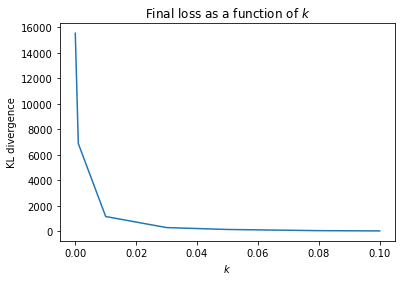

In [17]:
# plot kl divergence against learning_rates
plt.plot(learning_rates, kl_list)
plt.xlabel(r'$k$')
plt.ylabel(r'KL divergence')
plt.title(r'Final loss as a function of $k$')
plt.show()

Comment on the trend you observe and use this plot to set the optimal learning rate.

In [18]:
# find optimal learning rate
lr_opt = learning_rates[np.argmin(kl_list)]
print(fr'The optimal learning rate is {lr_opt}.')

The optimal learning rate is 0.1.


From the graph we can see that final loss decreases when learning rate increase and the absolute value of the gradient of the curve decreases as well. The optimal learning rate is $0.1$.

1.1.2

Retrain the MLP with the optimal learning rate, using batches of 128 data points and 40 epochs again. 

In [19]:
# initialise the parameters
kl_train_list = []
kl_test_list = []
acc_train_list = []
acc_test_list = []

# retrain MLP with optimal learning rate
var0 = 2. / (200 + 784)
W0 = np.random.randn(784, 200) * np.sqrt(var0)
b0 = np.zeros(200)

var1 = 2. / (200 + 200)
W1 = np.random.randn(200, 200) * np.sqrt(var1)
b1 = np.zeros(200)

var2 = 2. / (200 + 200)
W2 = np.random.randn(200, 200) * np.sqrt(var2)
b2 = np.zeros(200)

var3 = 2. / (10 + 200)
W3 = np.random.randn(200, 10) * np.sqrt(var3)
b3 = np.zeros(10)

# train MLP
for _ in range(epochs):
    for index in range(0, X_train_MNIST.shape[0], batch_size):
        
        # divide data into batches
        X_train_MNIST_batch = X_train_MNIST[index:min(index + batch_size, X_train_MNIST.shape[0]),:]
        y_train_MNIST_ohe_batch = y_train_MNIST_ohe[index:min(index + batch_size, X_train_MNIST.shape[0]),:]
        
        # update parameters by SGD
        W0, b0, W1, b1, W2, b2, W3, b3 = update_para(X_train_MNIST_batch, lr, y_train_MNIST_ohe_batch, W0, b0, W1, b1, W2, b2, W3, b3)
    
    # prediction
    y_train_pred_opt_ohe = mlp(X_train_MNIST, W0, b0, W1, b1, W2, b2, W3, b3)
    y_test_pred_opt_ohe = mlp(X_test_MNIST, W0, b0, W1, b1, W2, b2, W3, b3)

    # calculate the number of correct predictions
    y_train_pred_opt = np.argmax(y_train_pred_opt_ohe, axis = 1)
    y_test_pred_opt = np.argmax(y_test_pred_opt_ohe, axis = 1)
    num_correct_train = np.sum(y_train_MNIST == y_train_pred_opt)
    num_correct_test = np.sum(y_test_MNIST == y_test_pred_opt)
    
    # calculate the accuracy 
    accuracy_train = num_correct_train / len(y_train_pred_opt)
    accuracy_test = num_correct_test / len(y_test_pred_opt)
    acc_train_list.append(accuracy_train)
    acc_test_list.append(accuracy_test)
    
    # calculate KL divergence
    kl_train = kl_divergence(y_train_MNIST_ohe, y_train_pred_opt_ohe)
    kl_test = kl_divergence(y_test_MNIST_ohe, y_test_pred_opt_ohe)
    kl_train_list.append(kl_train)
    kl_test_list.append(kl_test)
    
# get activations of the units in the first hidden layer on a batch of the test data
X_test_MNIST_batch = X_test_MNIST[0:128,:]
y_test_pred_opt_batch, h1_test_batch = mlp(X_test_MNIST_batch, W0, b0, W1, b1, W2, b2, W3, b3, return_h1 = True)

Plot the loss and the accuracy of the MLP as a function of the number of epochs for both the training and test sets.

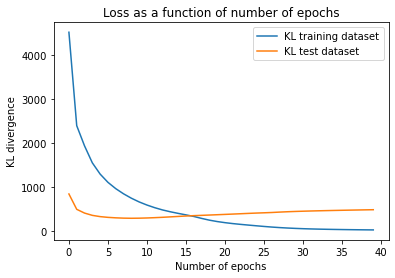

In [20]:
# plot kl divergence against number of epochs
plt.plot(range(40), kl_train_list, label = f'KL training dataset')
plt.plot(range(40), kl_test_list, label = f'KL test dataset')
plt.xlabel(r'Number of epochs')
plt.ylabel(r'KL divergence')
plt.title(r'Loss as a function of number of epochs')
plt.legend()
plt.show()

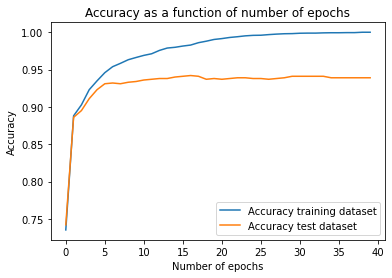

In [21]:
# plot accuracy against number of epochs
plt.plot(range(40), acc_train_list, label = f'Accuracy training dataset')
plt.plot(range(40), acc_test_list, label = f'Accuracy test dataset')
plt.xlabel(r'Number of epochs')
plt.ylabel(r'Accuracy')
plt.title(r'Accuracy as a function of number of epochs')
plt.legend()
plt.show()

1.1.3

Retrain the MLP of task 1.1.2, reducing the width of the hidden layers width to 50 neurons. Evaluate the accuracy on both the training and test sets and compare it to the accuracies of the MLP of task 1.1.2.

In [24]:
# initialise the parameters
acc_train_list_50 = []
acc_test_list_50 = []

# retrain MLP with optimal learning rate
var0 = 2. / (50 + 784)
W0 = np.random.randn(784, 50) * np.sqrt(var0)
b0 = np.zeros(50)

var1 = 2. / (50 + 50)
W1 = np.random.randn(50, 50) * np.sqrt(var1)
b1 = np.zeros(50)

var2 = 2. / (50 + 50)
W2 = np.random.randn(50, 50) * np.sqrt(var2)
b2 = np.zeros(50)

var3 = 2. / (10 + 50)
W3 = np.random.randn(50, 10) * np.sqrt(var3)
b3 = np.zeros(10)

# train MLP
for _ in range(epochs):
    for index in range(0, X_train_MNIST.shape[0], batch_size):
        
        # divide data into batches
        X_train_MNIST_batch = X_train_MNIST[index:min(index + batch_size, X_train_MNIST.shape[0]),:]
        y_train_MNIST_ohe_batch = y_train_MNIST_ohe[index:min(index + batch_size, X_train_MNIST.shape[0]),:]
        
        # update parameters by SGD
        W0, b0, W1, b1, W2, b2, W3, b3 = update_para(X_train_MNIST_batch, lr, y_train_MNIST_ohe_batch, W0, b0, W1, b1, W2, b2, W3, b3)
        
    # prediction
    y_train_pred_opt_ohe = mlp(X_train_MNIST, W0, b0, W1, b1, W2, b2, W3, b3)
    y_test_pred_opt_ohe = mlp(X_test_MNIST, W0, b0, W1, b1, W2, b2, W3, b3)
    
    # calculate the number of correct predictions
    y_train_pred_opt = np.argmax(y_train_pred_opt_ohe, axis = 1)
    y_test_pred_opt = np.argmax(y_test_pred_opt_ohe, axis = 1)
    num_correct_train = np.sum(y_train_MNIST == y_train_pred_opt)
    num_correct_test = np.sum(y_test_MNIST == y_test_pred_opt)
    
    # calculate the accuracy 
    accuracy_train = num_correct_train / len(y_train_pred_opt)
    accuracy_test = num_correct_test / len(y_test_pred_opt)
    acc_train_list_50.append(accuracy_train)
    acc_test_list_50.append(accuracy_test)

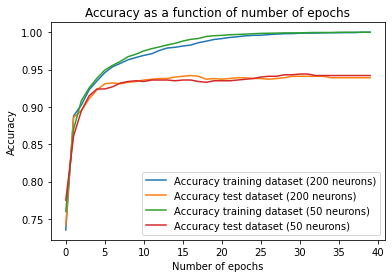

In [25]:
# plot accuracy against number of epochs
plt.plot(range(40), acc_train_list, label = f'Accuracy training dataset (200 neurons)')
plt.plot(range(40), acc_test_list, label = f'Accuracy test dataset (200 neurons)')
plt.plot(range(40), acc_train_list_50, label = f'Accuracy training dataset (50 neurons)')
plt.plot(range(40), acc_test_list_50, label = f'Accuracy test dataset (50 neurons)')
plt.xlabel(r'Number of epochs')
plt.ylabel(r'Accuracy')
plt.title(r'Accuracy as a function of number of epochs')
plt.legend()
plt.show()

From the graph, we can see that both the training and test accuracies increase as the number of epochs increases. This indicates that the model is improving and learning more as it is trained on more data. However, the test accuracy becomes stable after around 30 epochs both models. So further training beyond these points may not result in significant improvements in test accuracy.

For both training and test datasets, model with 50-neuron hidden layer is more accurate after 15 epochs. So there may be overfitting problem caused by the width of hidden layers. The gap between the accuracy of training dataset and the accuracy of test dataset also indicates that there may be overfitting problem.

1.1.4

Introduce in the MLP from task 1.1.2 a dropout with rate $0.2$ at each hidden layer and scale the output of each neuron in the hidden layers to compensate for the dropout during training. 

In [26]:
def dropout(x, dropout_rate = 0.2):
    
    # add a dropout mask to x and scale x to compensate for the dropou
    mask = np.random.binomial(1, 1 - dropout_rate, size=x.shape) / (1 - dropout_rate)
    
    return x * mask

In [27]:
def update_para_dropout(x_batch, learning_rate, y_batch, W0, b0, W1, b1, W2, b2, W3, b3):
    """
    Arguments:
        x_batch: K x 784 input data
        y_batch: K x 10 observations
        learning_rate: scalar represent learning rate in SGD process
        W0, W1, W2, W3: weight matrix
        b0, b1, b2, b3: bias array
    Returns:
        W0, W1, W2, W3, b0, b1, b2, b3 update by optimising loss function with dropout
    """
    
    # add a dropout mask to each post-activations
    h0 = x_batch
    a1 = dense(h0, W0, b0)
    h1 = softplus(a1)
    h1 = dropout(h1)
    a2 = dense(h1, W1, b1)
    h2 = softplus(a2)
    h2 = dropout(h2)
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3)
    h3 = dropout(h3)
    a4 = dense(h3, W3, b3)
        
    # calculate derivative of loss function
    delta4 = output_error(y_batch, a4)
    delta3 = backpropagate(delta4, W3, a3)
    delta2 = backpropagate(delta3, W2, a2) 
    delta1 = backpropagate(delta2, W1, a1)
    grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3)
    
    # stochastic gradient descent
    W0 -= learning_rate * grad_W0
    W1 -= learning_rate * grad_W1
    W2 -= learning_rate * grad_W2
    W3 -= learning_rate * grad_W3
    b0 -= learning_rate * grad_b0
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    b3 -= learning_rate * grad_b3
    
    return W0, b0, W1, b1, W2, b2, W3, b3

In [28]:
# initialise the parameters
kl_train_list_dropout = []
kl_test_list_dropout = []
acc_train_list_dropout = []
acc_test_list_dropout = []

# retrain MLP with optimal learning rate
var0 = 2. / (200 + 784)
W0 = np.random.randn(784, 200) * np.sqrt(var0)
b0 = np.zeros(200)

var1 = 2. / (200 + 200)
W1 = np.random.randn(200, 200) * np.sqrt(var1)
b1 = np.zeros(200)

var2 = 2. / (200 + 200)
W2 = np.random.randn(200, 200) * np.sqrt(var2)
b2 = np.zeros(200)

var3 = 2. / (10 + 200)
W3 = np.random.randn(200, 10) * np.sqrt(var3)
b3 = np.zeros(10)

# train MLP
for _ in range(150):
    for index in range(0, X_train_MNIST.shape[0], batch_size):
        
        # divide data into batches
        X_train_MNIST_batch = X_train_MNIST[index:min(index + batch_size, X_train_MNIST.shape[0]),:]
        y_train_MNIST_ohe_batch = y_train_MNIST_ohe[index:min(index + batch_size, X_train_MNIST.shape[0]),:]
        
        # update parameters by SGD with dropout
        W0, b0, W1, b1, W2, b2, W3, b3 = update_para_dropout(X_train_MNIST_batch, 0.1, y_train_MNIST_ohe_batch, \
                                                             W0, b0, W1, b1, W2, b2, W3, b3)
        
    # prediction
    y_train_pred_opt_ohe = mlp(X_train_MNIST, W0, b0, W1, b1, W2, b2, W3, b3)
    y_test_pred_opt_ohe = mlp(X_test_MNIST, W0, b0, W1, b1, W2, b2, W3, b3)
    
    # calculate the number of correct predictions
    y_train_pred_opt = np.argmax(y_train_pred_opt_ohe, axis = 1)
    y_test_pred_opt = np.argmax(y_test_pred_opt_ohe, axis = 1)
    num_correct_train = np.sum(y_train_MNIST == y_train_pred_opt)
    num_correct_test = np.sum(y_test_MNIST == y_test_pred_opt)
    
    # calculate the accuracy 
    accuracy_train = num_correct_train / len(y_train_pred_opt)
    accuracy_test = num_correct_test / len(y_test_pred_opt)
    acc_train_list_dropout.append(accuracy_train)
    acc_test_list_dropout.append(accuracy_test)
    
    # calculate KL divergence
    kl_train = kl_divergence(y_train_MNIST_ohe, y_train_pred_opt_ohe)
    kl_test = kl_divergence(y_test_MNIST_ohe, y_test_pred_opt_ohe)
    kl_train_list_dropout.append(kl_train)
    kl_test_list_dropout.append(kl_test)

# get activations of the units in the first hidden layer on a batch of the test data
X_test_MNIST_batch = X_test_MNIST[0:128,:]
y_test_pred_opt_batch_dropout, h1_test_batch_dropout = mlp(X_test_MNIST_batch, W0, b0, W1, b1, W2, b2, W3, b3, return_h1 = True)

Plot the loss and the accuracy of the MLP as a function of the number of epochs for both the training and test sets to demonstrate convergence. Use $80$ epochs and $0.1$ learning rate.

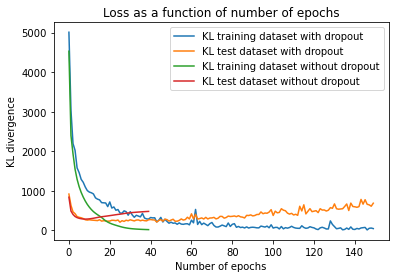

In [29]:
# plot kl divergence against number of epochs
plt.plot(range(150), kl_train_list_dropout, label = f'KL training dataset with dropout')
plt.plot(range(150), kl_test_list_dropout, label = f'KL test dataset with dropout')
plt.plot(range(40), kl_train_list, label = f'KL training dataset without dropout')
plt.plot(range(40), kl_test_list, label = f'KL test dataset without dropout')
plt.xlabel(r'Number of epochs')
plt.ylabel(r'KL divergence')
plt.title(r'Loss as a function of number of epochs')
plt.legend()
plt.show()

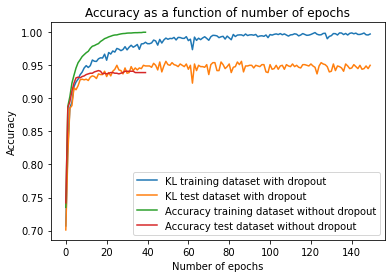

In [30]:
# plot accuracy against number of epochs
plt.plot(range(150), acc_train_list_dropout, label = f'KL training dataset with dropout')
plt.plot(range(150), acc_test_list_dropout, label = f'KL test dataset with dropout')
plt.plot(range(40), acc_train_list, label = f'Accuracy training dataset without dropout')
plt.plot(range(40), acc_test_list, label = f'Accuracy test dataset without dropout')
plt.xlabel(r'Number of epochs')
plt.ylabel(r'Accuracy')
plt.title(r'Accuracy as a function of number of epochs')
plt.legend()
plt.show()

Produce histograms of the activations of the units in the first hidden layer when the network is evaluated on a batch size of $128$ of the test data, both for the network with dropout and without dropout.

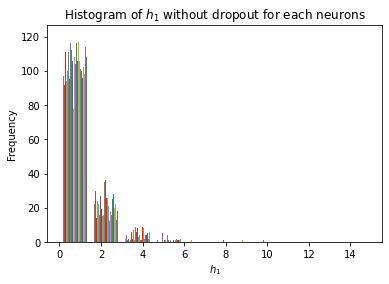

In [31]:
plt.hist(h1_test_batch)
plt.xlabel(r'$h_1$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of $h_1$ without dropout for each neurons')
plt.show()

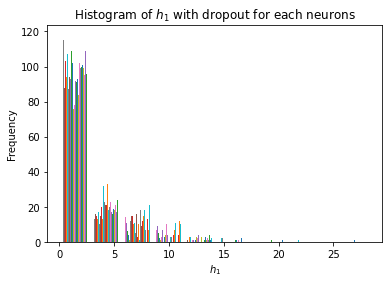

In [32]:
plt.hist(h1_test_batch_dropout)
plt.xlabel(r'$h_1$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of $h_1$ with dropout for each neurons')
plt.show()

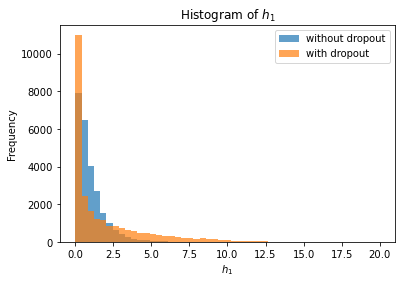

In [33]:
h1_test_batch_reshape = h1_test_batch.flatten()
h1_test_batch_dropout_reshape = h1_test_batch_dropout.flatten()

bins = np.linspace(0, 20, 50)

plt.hist(h1_test_batch_reshape, bins, alpha=0.7, label='without dropout')
plt.hist(h1_test_batch_dropout_reshape, bins, alpha=0.7, label='with dropout')
plt.xlabel(r'$h_1$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of $h_1$')
plt.legend()
plt.show()

From the graph, the histogram for the network with dropout has a higher concentration of low activation values and spread more evenly for $h_1>2.5$. This is because dropout randomly sets some columns of weight matrix (equivalently some of the activations) to zero during training. 

Dropout can help to force the neurons to learn more independent features and avoid overfitting, thus improve the performance of MLP model when dealing with unseen data. We can see that the accuracy of model with dropout on test dataset is higher than that of model without dropout and the loss is smaller. However, for training dataset, the accuracy of model with dropout is lower and loss is higher. This is acceptable since the model with dropout ignore some features in training dataset to prevent overfitting problem.

Another thing to notice is that when number of epochs increases, the loss on test dataset first decreases and then increases. This is overfitting problem caused by number of training iterations.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

First load the `.txt` files and standardise the data for PCA.

In [34]:
# load data
MNIST_train_noisy = np.loadtxt('MNIST_train_noisy.txt')
MNIST_test_noisy = np.loadtxt('MNIST_test_noisy.txt')

In [35]:
# standardise the inputs
X_train_MNIST_noisy, mu_train_MNIST_noisy, sigma_train_MNIST_noisy = standardise(MNIST_train_noisy)
X_test_MNIST_noisy = (MNIST_test_noisy - mu_train_MNIST_noisy) / sigma_train_MNIST_noisy

Function to perform PCA - use $m$ to denote the number of principal components.

In [36]:
from scipy.sparse import linalg

def pca_function(X,m):

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

Perform PCA to carry out dimensionality reduction. 

In [37]:
# initialise parameters
a, b = np.shape(X_train_MNIST_noisy)
explained_variances_list = []

# perform PCA on different m
for i in range(1, b):
    
    X_pca, eigenvectors, eigenvalues = pca_function(X_train_MNIST_noisy, i) 
    
    # calculate toatl variance
    C = 1.0 / (len(X_train_MNIST_noisy)-1) * np.dot(X_train_MNIST_noisy.T, X_train_MNIST_noisy)
    all_eigenvalues, _ = np.linalg.eig(C)
    total_variance = abs(all_eigenvalues.sum())

    # calculate explained variance
    explained_variances = np.sum(eigenvalues / total_variance)
    explained_variances_list.append(explained_variances)

Plot the fraction of variance explained by PCA as $m$ is increased.

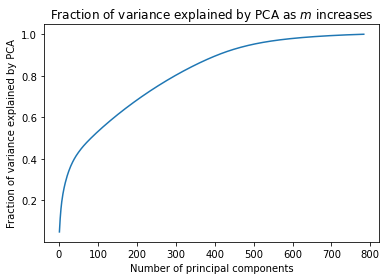

In [38]:
# plot the fraction of variance explained by PCA as m is increased
m_list = range(1, b)
plt.plot(m_list, explained_variances_list)
plt.xlabel('Number of principal components')
plt.ylabel('Fraction of variance explained by PCA')
plt.title(r'Fraction of variance explained by PCA as $m$ increases')
plt.show()

Provide the 3 values of $m$ at which, respectively, 70%, 80% and 90% of the variance is explained.

In [39]:
m_70 = np.argmin(abs(np.array(explained_variances_list) - 0.7)) + 1
m_80 = np.argmin(abs(np.array(explained_variances_list) - 0.8)) + 1
m_90 = np.argmin(abs(np.array(explained_variances_list) - 0.9)) + 1

print(fr'm when fraction of variance explained by PCA = 70% is {m_70}')
print(fr'm when fraction of variance explained by PCA = 80% is {m_80}')
print(fr'm when fraction of variance explained by PCA = 90% is {m_90}')

m when fraction of variance explained by PCA = 70% is 213
m when fraction of variance explained by PCA = 80% is 298
m when fraction of variance explained by PCA = 90% is 407


Using imshow to visualise the first $m=10$ principal components from PCA.

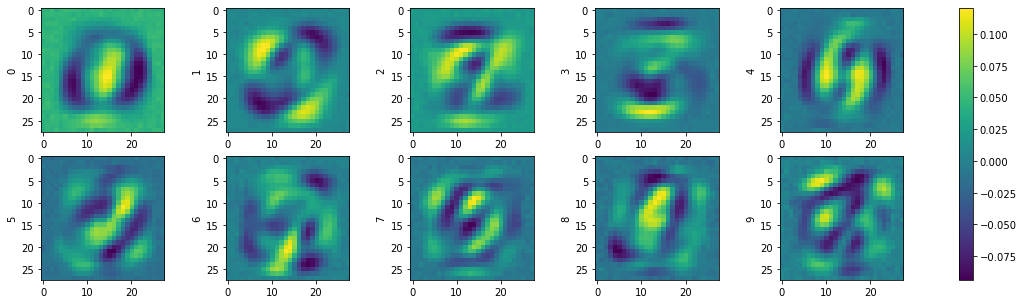

In [40]:
m = 10
X_pca, eigenvectors, eigenvalues = pca_function(X_train_MNIST_noisy, m)

nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows = nrow, ncols = ncol, figsize = (20,5))

for i, ax in enumerate(axs.reshape(-1)): 
    im = ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_ylabel(str(i))
    
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

1.2.2

Perform dimensionality reduction implementing NMF, with $m=10$ dimensions onto which to project the data.

First normalise the original data `MNIST_train_noisy` and `MNIST_test_noisy` between 0 and 1 for NMF.

In [41]:
# normalise min max to 0-1
def normalize_nmf(X):
    X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

X_MNIST_train_noisy_nmf = normalize_nmf(MNIST_train_noisy)
X_MNIST_test_noisy_nmf = normalize_nmf(MNIST_test_noisy)

Define cost function as the square of the Euclidean distance between the data $X$ and the product $WH$:

$$
||X - WH||^2 = \frac{1}{NP}\sum_{ij}(X_{ij} - (WH)_{ij})^2
$$
where $N$ and $P$ are numbers of rows and columns of $X$.

In [42]:
# define a cost matrix to compare the difference
def cost(X,W,H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)
    
    # compute the Euclidean distance-based objective function (normalized the sum by the nummber of terms in the sum)
    cost_value = (diff * diff).sum() / (X.shape[0] * X.shape[1])

    return cost_value

First implement the update on $H$ and then the update on $W$, finally compute the objective function.

In [43]:
def nmf_function(X, m, n_iters = 500, pseudo_count = 1e-6):
    
    # m x P matrix interpreted as the basis set, where m is the number of components, P the number of features of the data
    H = np.random.rand(m, X.shape[1])
    
    # N x m components matrix, usually interpreted as the coefficients, N is the number of data
    W = np.random.rand(X.shape[0], m)
    
    # empty list 
    cost_values = []
    
    # loop over the n iterations
    for i in range(n_iters):

        # compute the update on H
        H = H * ((W.T.dot(X)) / (W.T.dot(W.dot(H)) + pseudo_count))

        # compute the update on W
        W = W * ((X.dot(H.T)) / (W.dot(H.dot(H.T)) + pseudo_count))
        
        # compute cost value
        cost_values.append(cost(X, W, H))
        
    return H, W, cost_values

In [44]:
# setting the random seed
np.random.seed(1235)

# train NMF
H_10, W_10, cost_values_10 = nmf_function(X_MNIST_train_noisy_nmf, 10, n_iters = 500, pseudo_count = 1e-6)

Plot the loss as a function of the number of iterations.

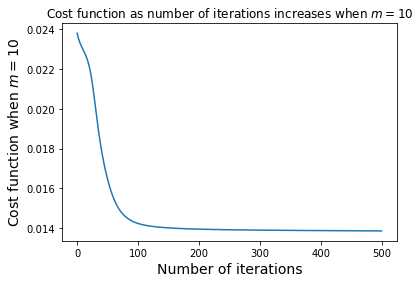

In [45]:
# plotting the cost
plt.plot(cost_values_10)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function when $m=10$', fontsize=14)
plt.title(r'Cost function as number of iterations increases when $m=10$')
plt.show()

The cost value converges after 200 iterations.

Visualise the $m=10$ NMF components using imshow.

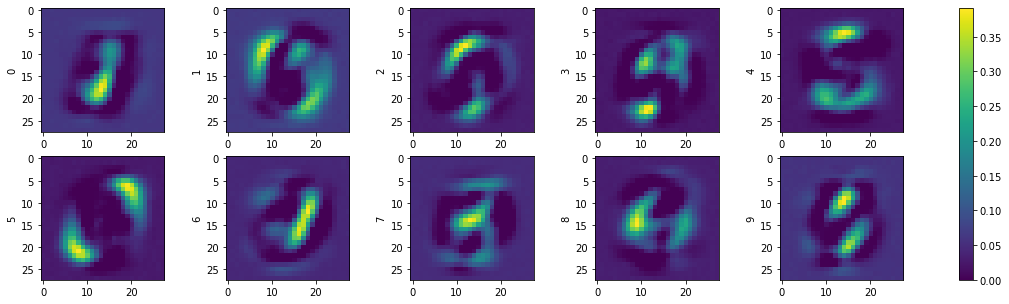

In [46]:
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows = nrow, ncols = ncol, figsize = (20,5))

for i,ax in enumerate(axs.reshape(-1)): 
    im = ax.imshow(H_10[i,:].reshape([28,28]))
    ax.set_ylabel(str(i))
    
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

The PCA components have positive and negative values, while the NMF components are non-negative. This is because PCA finds components with maximum variance between each other, but NMF finds a non-negative matrix factorization.

Additionally, the PCA captures the reduced number of features after dimensionality reduction. These directions are chosen to be orthogonal. The NMF components are often non-orthogonal and may represent different parts of the data.

1.2.3

Train PCA and NMF on `MNIST_train_noisy.txt` to find the set of principal components in PCA and non-negative components in NMF, using $m = 100$ for both PCA and NMF. 

In [47]:
# train PCA using m = 100, eigenvectors is the set of principal components in PCA
X_pca_100, eigenvectors_100, eigenvalues_100 = pca_function(X_train_MNIST_noisy, 100)

# setting the random seed
np.random.seed(1235)

# train NMF using m = 100, H is the set of principal components in NMF
H_100, W_100, cost_values_100 = nmf_function(X_MNIST_train_noisy_nmf, 100, n_iters = 500)

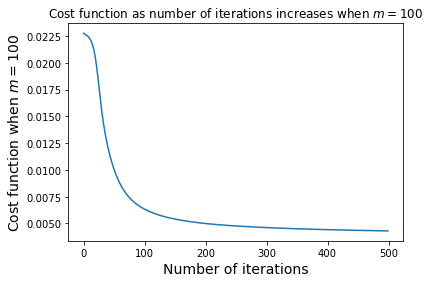

In [48]:
# show convergence result for NMF
plt.plot(cost_values_100)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function when $m=100$', fontsize=14)
plt.title(r'Cost function as number of iterations increases when $m=100$')
plt.show()

From the graph we can see the result converges for the NMF.

Consider now the test set `MNIST_test_noisy.txt` and write the formula to find, for each image in this set, the corresponding reconstructed image as a linear combination of the principal components in PCA and of the non-negative components in NMF.

For PCA, project standardised data `X_test_MNIST_noisy` onto the principal components using the formula:

$$
\hat{X}_{\text{test}}^{(i)} = \sum^{m}_{j=1}\left(\left(X_{\text{test}}^{(i)}\right)^T * \theta_j\right)\theta_j
$$
where $\theta_j$ is the matrix of principal components obtained from PCA. The $\hat{X}_{\text{test}}^{(i)}$ needs to be recenter and scale since we standardised the training and test data sets.

For NMF, use normalised data `X_test_MNIST_noisy_nmf` and the non-negative matrix factorization to find the coefficients of the linear combination of the non-negative components:

$$
\hat{X}_{\text{test}}^{(i)} =  H^T w^{(i)}
$$
where $H^T$ contains rows of the non-negative components and $w^{(i)}$ is the non-negative coefficients obtained by optimisation on test data set.

In [49]:
# formula for PCA reconstruction 
def reconstruct_pca(X, V):
    return X @ V @ V.T

Choose an image from the noisy test set and visualise it along with its original version (from `MNIST_test.csv`) and its reconstructed version by both PCA and NMF with $m = 100$.

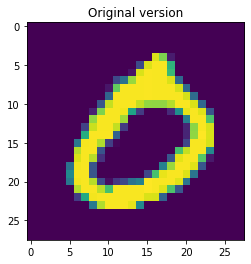

In [50]:
# original version
plt.imshow(X_test_MNIST_org[0,:].reshape([28,28]))
plt.title(fr'Original version')
plt.show()

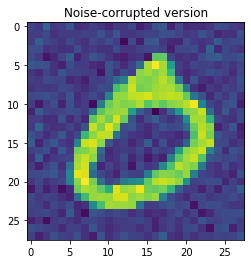

In [51]:
# noisy version
plt.imshow(MNIST_test_noisy[0,:].reshape([28,28]))
plt.title(fr'Noise-corrupted version')
plt.show()

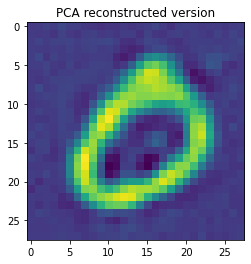

In [52]:
# PCA reconstruct version
X_pca = reconstruct_pca(X_test_MNIST_noisy, eigenvectors_100)
X_pca_reconstruct = X_pca * sigma_train_MNIST_noisy + mu_train_MNIST_noisy # rescaling data
plt.imshow(X_pca_reconstruct[0,:].reshape([28,28]))
plt.title(fr'PCA reconstructed version')
plt.show()

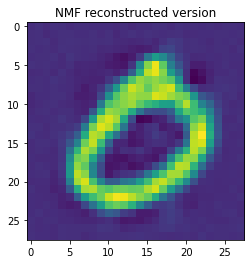

In [53]:
# NMF reconstruct version
W_test_nmf = np.random.rand(X_MNIST_test_noisy_nmf.shape[0], 100)
# calculate coefficients on test dataset
for i in range(500):
    W_test_nmf = W_test_nmf * ((X_MNIST_test_noisy_nmf.dot(H_100.T)) / (W_test_nmf.dot(H_100.dot(H_100.T)) + 1e-6))
X_nmf = W_test_nmf @ H_100
X_nmf_reconstruct = (X_nmf * (np.max(MNIST_test_noisy) - np.min(MNIST_test_noisy))) +  np.min(MNIST_test_noisy) # rescaling data
plt.imshow(X_nmf_reconstruct[0,:].reshape([28,28]))
plt.title(fr'NMF reconstructed version')
plt.show()

The reconstructed images by PCA and NMF denoising methods are similar to the original image, indicates that both methods remove a significant amount of noise from the noise-corrupted image. However, upon closer inspection, the NMF reconstructed image appears to be more visually pleasing and accurate compared to the PCA reconstructed image.

The PCA method ignore features with small eigenvalues, so some fine details may be lost. The NMF method is based on the non-negative matrix factorization so is able to reconstruct a more detailed image compared to the PCA method.

1.2.4

Compute the Mean-Squared Error (MSE) between the reconstructed images with PCA implementation and (i) the test set of uncorrupted images (`MNIST_test.csv`) and (ii) the test set of noise-corrupted images (`MNIST_test_noisy.txt`).

In [54]:
# define function of MSE
def MSE(X1, X2):
  
    # compute the difference between X1 and X2
    diff = X1 - X2 
    
    # compute the MSE
    MSE_value = (diff * diff).sum() / (X1.shape[0] * X1.shape[1])
    
    return MSE_value

In [55]:
# MSE between reconstructed images and the test set of uncorrupted images
MSE_MNIST_test = MSE(X_pca_reconstruct, X_test_MNIST_org)
print(fr"MSE between the reconstructed images with PCA implementation and the test set of uncorrupted images is {MSE_MNIST_test}")

# MSE between reconstructed images and the test set of noise-corrupted images
MSE_MNIST_test_noisy = MSE(X_pca_reconstruct, MNIST_test_noisy)
print(fr"MSE between the reconstructed images with PCA implementation and the test set of noise-corrupted images is {MSE_MNIST_test_noisy}")

MSE between the reconstructed images with PCA implementation and the test set of uncorrupted images is 801.6011242194653
MSE between the reconstructed images with PCA implementation and the test set of noise-corrupted images is 1100.9829861592782


Plot, on the same figure, these two MSEs as a function of the number of PCA components $m$, varying $m$ in the interval $5-400$ with a step size $5$. Explain the results plotted.

In [56]:
# initialise parameters
m_list_MSE = range(5, 401, 5)
MSE_test_list = []
MSE_test_noisy_list = []

# calculate MSE with varying m
for m in m_list_MSE:
    
    # reconstruction of images
    X_m, eigenvectors_m, eigenvalues_m = pca_function(X_train_MNIST_noisy, m)
    X_pca_m = reconstruct_pca(X_test_MNIST_noisy, eigenvectors_m)
    X_pca_reconstruct_m = X_pca_m * sigma_train_MNIST_noisy + mu_train_MNIST_noisy
    
    # MSE compared to uncorrupted images
    MSE_MNIST_test_m = MSE(X_pca_reconstruct_m, X_test_MNIST_org)
    MSE_test_list.append(MSE_MNIST_test_m)
    
    # MSE compared to noise-corrupted images
    MSE_MNIST_test_noisy_m = MSE(X_pca_reconstruct_m, MNIST_test_noisy)
    MSE_test_noisy_list.append(MSE_MNIST_test_noisy_m)

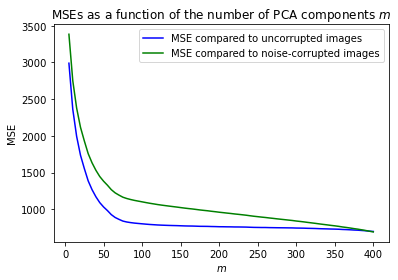

In [57]:
# plot MSE with varying m
plt.title(f"MSEs as a function of the number of PCA components $m$")
plt.plot(m_list_MSE, MSE_test_list, 'b', label = f'MSE compared to uncorrupted images')
plt.plot(m_list_MSE, MSE_test_noisy_list, 'g', label = f'MSE compared to noise-corrupted images')
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.legend()
plt.show()

Generally the MSE between reconstructed image and the noise-corrupted image is larger. This is because PCA method reduces the amount of noise by choosing features with large eigenvalues. 

The MSE between reconstructed image and the original image converges faster. At $m=400$, the two curves coincide at this position. This is because when $m$ increases, less features are omitted. So less amount of noise has been removed.

Like in 1.2.3, visualise an example of a reconstructed image for $m = 10, 40, 100, 200$ to illustrate your discussion of the MSEs.

MSE between the reconstructed images and the test set of uncorrupted images when m=10 is 2362.3828114005105
MSE between the reconstructed images and the test set of noise-corrupted images when m=10 is 2752.3169505997434


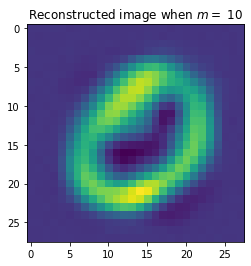

MSE between the reconstructed images and the test set of uncorrupted images when m=40 is 1170.46548234679
MSE between the reconstructed images and the test set of noise-corrupted images when m=40 is 1531.164463310836


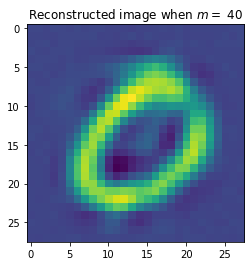

MSE between the reconstructed images and the test set of uncorrupted images when m=100 is 801.6011242194652
MSE between the reconstructed images and the test set of noise-corrupted images when m=100 is 1100.9829861592782


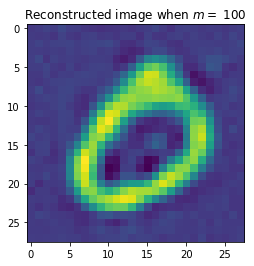

MSE between the reconstructed images and the test set of uncorrupted images when m=200 is 761.9702147269396
MSE between the reconstructed images and the test set of noise-corrupted images when m=200 is 959.5995019064428


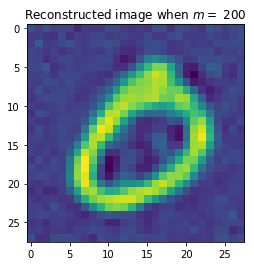

In [58]:
# initialise parameters
m_list_reconstruct = [10, 40, 100, 200]

# calculate MSE and plot the reconstructed image
for m in m_list_reconstruct:
    
    # reconstruction of images
    X_m, eigenvectors_m, eigenvalues_m = pca_function(X_train_MNIST_noisy, m)
    X_pca_m = reconstruct_pca(X_test_MNIST_noisy, eigenvectors_m)
    X_pca_reconstruct_m = X_pca_m * sigma_train_MNIST_noisy + mu_train_MNIST_noisy
    
    # MSE compared to uncorrupted images
    MSE_MNIST_test_m = MSE(X_pca_reconstruct_m, X_test_MNIST_org)
    print(fr"MSE between the reconstructed images and the test set of uncorrupted images when m={m} is {MSE_MNIST_test_m}")
    
    # MSE compared to noise-corrupted images
    MSE_MNIST_test_noisy_m = MSE(X_pca_reconstruct_m, MNIST_test_noisy)
    print(fr"MSE between the reconstructed images and the test set of noise-corrupted images when m={m} is {MSE_MNIST_test_noisy_m}")
    
    plt.imshow(X_pca_reconstruct_m[0,:].reshape([28,28]))
    plt.title(fr"Reconstructed image when $m = $ {m}")
    plt.show()

When $m$ is smaller, the reconstructed image is more blurred and smooth and MSEs are larger. This is because a lot of features have been removed, therefore the image would be less accurate.

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

Use the first $5$ principal components of the PCA on the first $N=1000$ images of the standardised training dataset `X_train_MNIST` to perform clustering using a Gaussian Mixture Model with $10$ hidden components.

In [59]:
# compute the first 5 principal components of the PCA on the first 1000 images
X_train_MNIST_1000 = X_train_MNIST[:1000, :]
X_pca_5, eigenvectors_5, eigenvalues_5 = pca_function(X_train_MNIST_1000, 5)

In [60]:
from scipy.stats import multivariate_normal 

class GMModel:
    """
    Struct to define Gaussian Mixture Model
    :param dim: number of mixture components
    :param weights: mixture weights
    :param mu: mixture component means for each cluster
    :param sigma: mixture component covariance matrix for each cluster
    """
    
    def __init__(self, X, dim):
        """
        Initialises parameters through random split of the data
        """
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

Function calculating the probability of each data point to belong to cluster $k$.

In [61]:
def cluster_probabilities(gmm, X):
    """
    Predicts probability of each data point with respect to each cluster
    """
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i])
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        
    return weights

Present the results as hard clusters.

In [62]:
def predict(gmm, X):
    """
    Performs hard clustering
    """
    
    weights = cluster_probabilities(gmm,X)
    
    return np.argmax(weights, axis=1)

Plot function to visualise the mixture model.

In [63]:
def plot_gmm(gmm, X, label=True, ax=None):
    
    ax = ax or plt.gca()
    labels = predict(gmm, X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    return ax

Employ the EM algorithm to fit the data.

In [64]:
def fitStep(gmm,X):
    """
    Performs an EM step by updating all parameters
    """
    
    # update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X)
    gmm.phi = weights.mean(axis=0)
        
    # update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

In [66]:
# perform clustering using GMM with 10 hidden components
np.random.seed(4321)
gmm = GMModel(X_pca_5, 10)
for _ in range(10000):
    fitStep(gmm, X_pca_5)

Visualise the space spanned by the top two principal components, colouring each point according to their cluster.

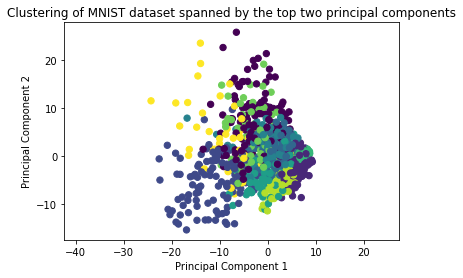

In [67]:
# visualise cluster in the space spanned by the top two principal components
plot_gmm(gmm, X_pca_5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering of MNIST dataset spanned by the top two principal components')
plt.show()

1.3.2

Use the class labels to visualise the space spanned by the top two principal components and colour each point according to their class label. 

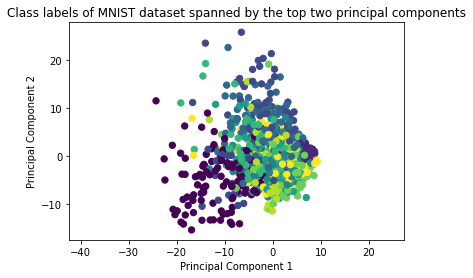

In [68]:
# visualise class labels in the space spanned by the top two principal components# 
ax = None
ax = ax or plt.gca()
ax.scatter(X_pca_5[:, 0], X_pca_5[:, 1], c=y_train_MNIST[:1000], s=40, cmap='viridis', zorder=2)
ax.axis('equal')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Class labels of MNIST dataset spanned by the top two principal components')
plt.show()

Map the class labels to the best-fitting cluster index, print and discuss the result.

In [69]:
def cluster_log_likelihood(gmm, X):
    """
    Predicts probability of each data point with respect to each cluster
    """
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i])
        likelihood[:,i] = distribution.pdf(X) 

    return np.log(likelihood + 1e-8) # avoid likelihood = 0

In [70]:
def log_likelihood(y_true, y_pred, X, gmm, k = 10):
    
    scores = np.zeros((10, k))
    for i in range(10):
        X_class_i = X[y_true == i]
        # calculate the log likelihood of each mixture component
        score = np.mean(cluster_log_likelihood(gmm, X_class_i), axis = 0)
        scores[i,:] = score
        
    return scores

In [71]:
y_true = y_train_MNIST[:1000]
y_pred = predict(gmm, X_pca_5)

# calculate log likelihood
scores = log_likelihood(y_true, y_pred, X_pca_5, gmm)

# choose the best-fitting cluster index
for i in range(10):
    score = np.argmax(scores[i, :])
    print(fr"The best-fitting cluster index for class label {i} is {score}")

The best-fitting cluster index for class label 0 is 2
The best-fitting cluster index for class label 1 is 6
The best-fitting cluster index for class label 2 is 0
The best-fitting cluster index for class label 3 is 7
The best-fitting cluster index for class label 4 is 4
The best-fitting cluster index for class label 5 is 8
The best-fitting cluster index for class label 6 is 3
The best-fitting cluster index for class label 7 is 1
The best-fitting cluster index for class label 8 is 8
The best-fitting cluster index for class label 9 is 4


There are two classes has best-fitting cluster 4 and two classes has best-fitting cluster 8. This indicates that the data within both classes may have common features that are best represented by the particular mixture component.

1.3.3

Use the label-cluster index map to compute the cluster probabilities for each digit. For each class, visualise the space spanned by the top two components by colouring each point according to the cluster probability of the best-fitting cluster. 

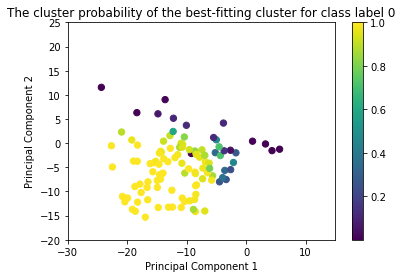

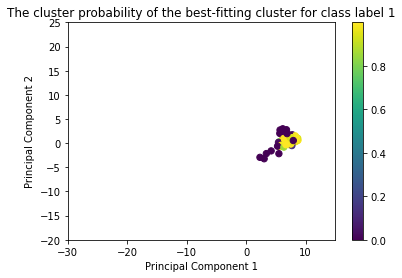

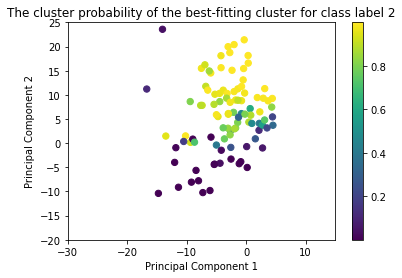

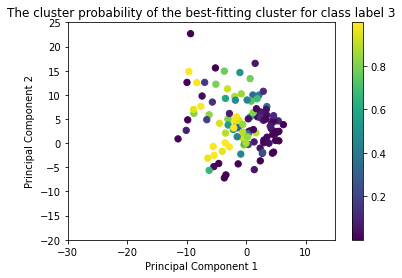

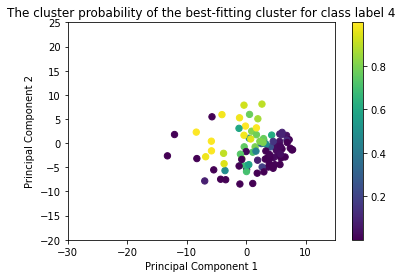

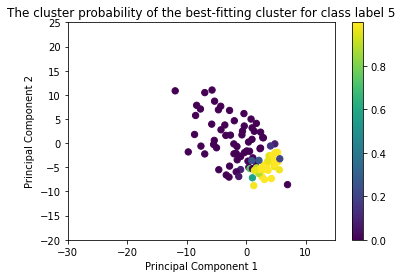

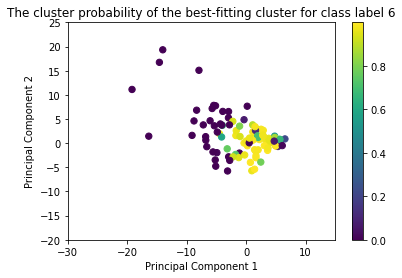

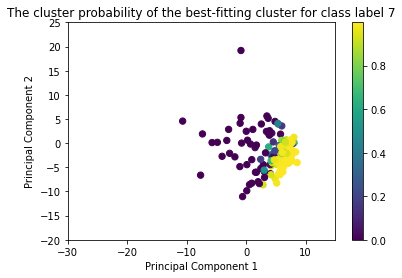

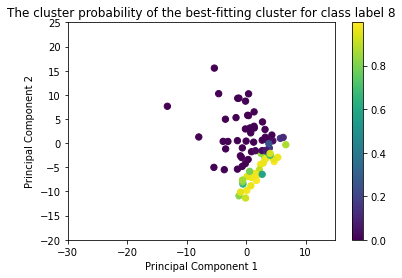

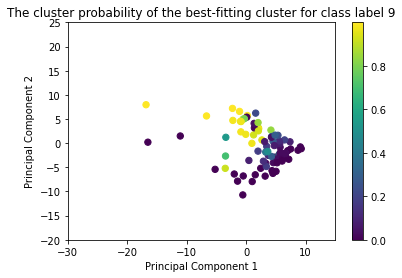

In [73]:
for i in range(10):
    # calculate cluster probabilities for each digit of the best-fitting cluster
    score = np.argmax(scores[i, :])
    X_i = X_pca_5[y_true == i]
    cluster_probability = cluster_probabilities(gmm, X_i)[:, score]
    
    # colouring each point according to the cluster probability in the space spanned by the top two components
    ax = None
    ax = ax or plt.gca()
    scatter = ax.scatter(X_i[:, 0], X_i[:, 1], c=cluster_probability, s=40, cmap='viridis', zorder=2)
    scatter.figsize = (20,5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(fr'The cluster probability of the best-fitting cluster for class label {i}')
    plt.colorbar(scatter)
    plt.xlim(-30, 15)
    plt.ylim(-20, 25)
    plt.show()

We can see from the plots that some classes have more data points with high cluster probabilities, while others have more data points spread out with lower cluster probabilities. For example, the points in class 0 and 2 have more data points with high cluster probability, while in class 5 and 9, more points have lower cluster probabilities.

There are uncertainty in the clustering algorithm as we use probability to assign a data point to a particular cluster. Some data points may not be classified correctly. In general, classes with more data points with high cluster probabilities correspond to digits that are easier to distinguish from each other. But for classes with similar features between the data points, it will be difficult for the clustering algorithm to assign them to the single true cluster.

1.3.4

Retrain the Gaussian Mixture Model with a reduced number of five and eight components.

In [74]:
# set the same seed as GMM with 10 components
np.random.seed(4321)
gmm_8 = GMModel(X_pca_5, 8)
for _ in range(100):
    fitStep(gmm_8, X_pca_5)
    
np.random.seed(4321)
gmm_5 = GMModel(X_pca_5, 5)
for _ in range(100):
    fitStep(gmm_5, X_pca_5)

Compute the map of the class labels to the best-fitting cluster index.

In [75]:
# calculate log likelihood
y_pred_8 = predict(gmm_8, X_pca_5)
y_pred_5 = predict(gmm_5, X_pca_5)
scores_8 = log_likelihood(y_true, y_pred_8, X_pca_5, gmm_8, k=8)
scores_5 = log_likelihood(y_true, y_pred_5, X_pca_5, gmm_5, k=5)

# choose the best-fitting cluster index
for i in range(10):
    score_8 = np.argmax(scores_8[i, :])
    score_5 = np.argmax(scores_5[i, :])
    print(fr"The best-fitting cluster index for class label {i} is {score_8} when there are 8 components in GMM.")
    print(fr"The best-fitting cluster index for class label {i} is {score_5} when there are 5 components in GMM.")

The best-fitting cluster index for class label 0 is 2 when there are 8 components in GMM.
The best-fitting cluster index for class label 0 is 2 when there are 5 components in GMM.
The best-fitting cluster index for class label 1 is 6 when there are 8 components in GMM.
The best-fitting cluster index for class label 1 is 1 when there are 5 components in GMM.
The best-fitting cluster index for class label 2 is 0 when there are 8 components in GMM.
The best-fitting cluster index for class label 2 is 0 when there are 5 components in GMM.
The best-fitting cluster index for class label 3 is 7 when there are 8 components in GMM.
The best-fitting cluster index for class label 3 is 3 when there are 5 components in GMM.
The best-fitting cluster index for class label 4 is 4 when there are 8 components in GMM.
The best-fitting cluster index for class label 4 is 4 when there are 5 components in GMM.
The best-fitting cluster index for class label 5 is 5 when there are 8 components in GMM.
The best-f

Below is the best-fitting cluster index for each class by GMM with different numbers of components:

|Class|0|1|2|3|4|5|6|7|8|9|
|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|
|10 Components|2|6|0|7|4|8|3|1|8|4|
|8 Components|2|6|0|7|4|5|3|1|5|4|
|5 Components|2|1|0|3|4|2|3|4|2|4|

Class 0, 2, 4, 6 and 9 have a consistent best-fitting cluster index across all three models, which indicates data in these classes may have features that make it easier to distinguish them from each other.

Generally, when the number of components decreases, there are more variability in the best-fitting cluster indices for each class. In contrast, when the number of components increases, the best-fitting cluster indices show more consistency, but may cause overfitting problem.

### Task 2: Clustering and graph-based analysis (35 marks)

First load the data `X_gene` and standardise to get `X_gene_std` as k-mean method uses distance-based measurements to cluster data.

In [76]:
# load data as pandas data frames
gene_expression_data = pd.read_csv('gene_expression_data.csv')
X_gene = gene_expression_data.iloc[:, :95]

In [77]:
# standardise the inputs
X_gene_std, mu_gene, sigma_gene = standardise(X_gene)

#### 2.1 Clustering (15 marks)
2.1.1

Implement k-means on these data to find groups of samples with similar gene expression patterns.

In [78]:
def k_mean_clustering(X, k, max_iter = 20, show = True):
    
    n_samples, n_features = X.shape

    # labels: assign every sample to a cluster at random
    labels = np.random.randint(low = 0, high = k, size = n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis = 1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        a_i = []
        for j in range(n_samples):
            if X_labels[j][-1] == i:
                a_i.append(X_labels[j])
        if len(a_i) == 0:
            centroids[i] = np.zeros(n_features)
        else:
            centroids[i] = np.mean(a_i, axis = 0)[0:n_features]
        
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        if show:
            print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels == new_labels).all():
            # labels unchanged
            labels = new_labels
            if show:
                print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            if show:
                print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    return centroids, labels

In [79]:
# implement k-means for k = 5
centroids_std, labels_std = k_mean_clustering(X_gene_std, 5, max_iter = 50)

Iteration: 0
75.500000% labels changed
Iteration: 1
21.750000% labels changed
Iteration: 2
10.375000% labels changed
Iteration: 3
4.500000% labels changed
Iteration: 4
7.625000% labels changed
Iteration: 5
11.750000% labels changed
Iteration: 6
10.875000% labels changed
Iteration: 7
6.625000% labels changed
Iteration: 8
3.625000% labels changed
Iteration: 9
1.125000% labels changed
Iteration: 10
0.625000% labels changed
Iteration: 11
0.375000% labels changed
Iteration: 12
0.125000% labels changed
Iteration: 13
Labels unchanged! Terminating k-means.


Code a function to compute the Calinski-Harabasz index of a given clustering, which measures the clustering quality based on a ratio of
the between-cluster scatter matrix, and the within-cluster scatter matrix.

In [80]:
def Calinski_Harabasz_index(X, centroids, labels):
    
    # initialise parameters
    n, features = X.shape
    k, features = centroids.shape
    c_tot = np.mean(X, axis = 0)
    BCSM = 0 
    WCSM = 0
    
    # compute BCSM and WCSM
    for i in range(k):
        X_i = X[labels == i]
        n_i = X_i.shape[0]
        c_i = np.mean(X_i, axis = 0)
        if n_i == 0:
            BCSM += 0
        else:
            BCSM += n_i * ((np.linalg.norm(c_i - c_tot)) ** 2)
        for j in range(len(X_i)):
            x_i = X_i.iloc[j, :]
            WCSM += (np.linalg.norm(x_i - c_i)) ** 2
   
    # compute CH index
    CH = (BCSM / (k - 1)) * ((n - k) / WCSM)
    
    return CH

Determine the optimal k, running k-means, for each k, for 5 different initialisations and averaging the corresponding Calinski-Harabasz indices.

In [82]:
# initialise parameters
k_list = range(2, 15)
CH_std = []

# run k-mean for different k
for i in k_list:
    CH_i = []
    # use 5 different initialisations
    for j in range(5):
        centroids_std, labels_std = k_mean_clustering(X_gene_std, i, max_iter = 50, show = False)
        CH_ij = Calinski_Harabasz_index(X_gene_std, centroids_std, labels_std)
        CH_i.append(CH_ij)
    # average CH index
    CH_avg_i = np.mean(CH_i)
    print(fr"The average Calinski-Harabasz index when k = {i} is {CH_avg_i}.")
    CH_std.append(CH_avg_i)
    
# find optimal k
best_k_index_std = np.argmax(CH_std)
print('Optimal k value:', k_list[best_k_index_std])

The average Calinski-Harabasz index when k = 2 is 206.32997698513336.
The average Calinski-Harabasz index when k = 3 is 218.75939524613304.
The average Calinski-Harabasz index when k = 4 is 232.9867297723416.
The average Calinski-Harabasz index when k = 5 is 206.5075043071803.
The average Calinski-Harabasz index when k = 6 is 178.95241530688332.
The average Calinski-Harabasz index when k = 7 is 160.07983401206383.
The average Calinski-Harabasz index when k = 8 is 144.48243151985116.
The average Calinski-Harabasz index when k = 9 is 137.46133997178117.
The average Calinski-Harabasz index when k = 10 is 123.51314188671638.
The average Calinski-Harabasz index when k = 11 is 119.36173602687174.
The average Calinski-Harabasz index when k = 12 is 118.84659917979397.
The average Calinski-Harabasz index when k = 13 is 110.26082307343954.
The average Calinski-Harabasz index when k = 14 is 108.58474614403376.
Optimal k value: 4


Provide the size of the clusters found by k-means with the optimal k. 

In [83]:
# train k-mean with optimal k
centroids_opt, labels_opt = k_mean_clustering(X_gene_std, k_list[best_k_index_std], max_iter = 50)

# calculate the size of each cluster
unique_labels_opt, counts_opt = np.unique(labels_opt, return_counts=True)
cluster_sizes_opt = dict(zip(unique_labels_opt, counts_opt))

print("Size of the clusters found by k-means with the optimal k is:", cluster_sizes_opt)

Iteration: 0
70.250000% labels changed
Iteration: 1
20.875000% labels changed
Iteration: 2
7.625000% labels changed
Iteration: 3
3.750000% labels changed
Iteration: 4
2.375000% labels changed
Iteration: 5
0.750000% labels changed
Iteration: 6
0.375000% labels changed
Iteration: 7
Labels unchanged! Terminating k-means.
Size of the clusters found by k-means with the optimal k is: {0: 221, 1: 303, 2: 141, 3: 135}


Plot the average Calinski-Harabasz index as a function of k.

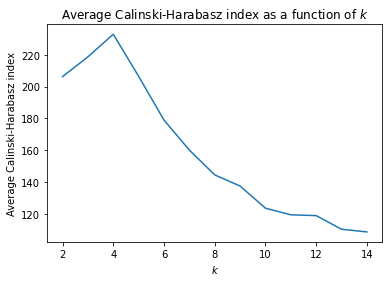

In [84]:
# plot average CH index against k
plt.plot(k_list, CH_std)
plt.xlabel(r'$k$')
plt.ylabel(r'Average Calinski-Harabasz index')
plt.title('Average Calinski-Harabasz index as a function of $k$')
plt.show()

2.1.2

Load true types `y_true`.

In [85]:
y_true = gene_expression_data.iloc[:, 95]

Code a function to compute the homogeneity score, a score measuring the extent to which the data points in one cluster belong to the same class. 

In [86]:
def homogeneity_score(X, C, K):
     
    # initialise parameters
    n, features = X.shape
    C_list = np.unique(C)
    K_list = np.unique(K)
    n_C = len(C_list)
    n_K = len(K_list)
    a = np.zeros((n_C, n_K))
    H_C = 0
    H_CK = 0
    
    # count number of data in each cluster of each type
    for i in range(n_C):
        for j in range(n_K):
            c = C_list[i]
            k = K_list[j]
            a_ck = np.sum((C == c) & (K == k))
            a[i, j] = a_ck
    
    sum_c_a_ck = np.sum(a, axis = 0)
    sum_k_a_ck = np.sum(a, axis = 1)
    
    # calculate homogeneity score
    for i in range(n_C):
        H_C -= (sum_k_a_ck[i] / n) * np.log(sum_k_a_ck[i] / n)
        for j in range(n_K):
            if a[i, j] == 0:
                H_CK -= 0
            else:
                H_CK -= (a[i, j] / n) * np.log(a[i, j] / sum_c_a_ck[j])
    
    HS = 1 - (H_CK / H_C)
    return HS

In [87]:
hs = homogeneity_score(X_gene_std, y_true, labels_opt)
print(fr'The homogeneity score between the clustering of the samples and the true classes is {hs}.')

The homogeneity score between the clustering of the samples and the true classes is 0.5867971369720714.


The best case of clustering is when $\sum^{|C|}_{i=1}a_{ik} = a_{ck}$ for all $c$ and $k$, which indicates that all data of one type are allocated to the same cluster. So a homogeneity score of 1 indicates perfect homogeneity. 

A homogeneity score of $0.587$ suggests that the clustering achieves moderate consistency with the sample tumour types. However, the interpretation of the score may depend on the context and the specific data set.

#### 2.2 Graph-based analysis (20 marks)
2.2.1

Compute the matrix of connected correlations between genes.

In [89]:
# matrix of connected correlations
corr_matrix = np.corrcoef(X_gene, rowvar =False)

Set to zero the diagonal terms and all the terms whose absolute value is smaller than 0.75.

In [90]:
# set diagonal elements to zero
np.fill_diagonal(corr_matrix, 0)

# threshold the correlation matrix
corr_matrix[abs(corr_matrix) < 0.75] = 0

Take the resulting matrix as the adjacency matrix $A$ of a weighted graph describing gene co-expression. Visualise the adjacency matrix $A$ using imshow.

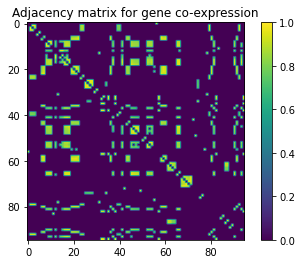

In [91]:
# visualize the adjacency matrix using imshow
plt.imshow(corr_matrix)
plt.colorbar()
plt.title('Adjacency matrix for gene co-expression')
plt.show()

2.2.2

Compute the degree centrality of each node (gene) in the network.

In [92]:
# compute the degree centrality of each node
degree = np.sum(corr_matrix, axis=1)
degree_centrality = degree / np.sum(degree)

Sort the genes in descending order by these values and print the index of the $5$ top ranking genes.

In [93]:
# sort the genes in descending order by degree centrality
sorted_genes = np.argsort(degree_centrality)[::-1]

# print the index of the top 5 ranking genes
print(fr'The index of the 5 top ranking genes is: {sorted_genes[:5]}')

The index of the 5 top ranking genes is: [17 41 16 81 90]


2.2.3

Compute the symmetric normalised Laplacian of the graph and derive its eigenvalues and eigenvectors.

In [94]:
from scipy.sparse import linalg

# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(corr_matrix.shape[0]) - D_inv_sqrt.dot(corr_matrix.dot(D_inv_sqrt))

# derive the eigenvalues and eigenvectors of the symmetric normalized Laplacian
eigenvalues, eigenvectors = np.linalg.eigh(L_norm)
eigenvalues = np.real_if_close(eigenvalues)

Plot the spectrum of eigenvalues, marking on the plot the gap between eigenvalues that, upon numerical rounding, have respectively zero and non-zero values. 

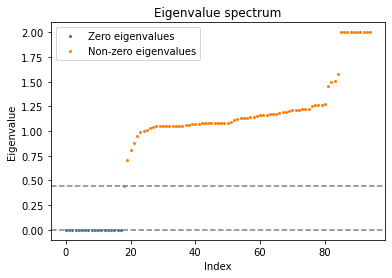

In [95]:
# find index of zero and non-zero eigenvalues upon numerical rounding
zero_idx = np.where(np.isclose(eigenvalues, 0))[0]
r = np.arange(len(eigenvalues))
non_zero_idx = np.setdiff1d(r, zero_idx)

# select the zero and non-zero eigenvalues
non_zero_eigenvalues = eigenvalues[non_zero_idx]
zero_eigenvalues = eigenvalues[zero_idx]

# mark the gap between zero and non-zero eigenvalues
plt.plot(zero_idx, zero_eigenvalues, 'o', markersize=2)
plt.plot(non_zero_idx, non_zero_eigenvalues, 'o', markersize=2)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue spectrum')
plt.legend(['Zero eigenvalues', 'Non-zero eigenvalues'])
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = non_zero_eigenvalues[0], linestyle = '--', color = 'gray')
plt.show()

Provide the number r of zero eigenvalues and explain what they tell about the network structure.

In [96]:
# count the number of zero eigenvalues
r = np.sum(np.isclose(eigenvalues, 0))
print(fr"Number of zero eigenvalues is {r}.")

Number of zero eigenvalues is 18.


This indicates that the network is not fully connected. Each zero eigenvalue corresponds to a disconnected subnetworks. Therefore, in this case, the network may have up to 18 separate subnetworks.

2.2.4

Form the matrices $U$ and $T$.

In [97]:
# form matrix U
U = eigenvectors[zero_idx].T

# form matrix T
denominator = np.linalg.norm(U, axis=1, keepdims=True)
T = U / denominator

Apply $k$-means to the matrix $T$ varying $k$. Use the normalised within-cluster distance and the elbow method to set the appropriate value of $k$. 

In [125]:
from scipy.spatial.distance import cdist

# function to compute the normalized within-cluster distance
def norm_within_cluster_dist(T, k, max_iter = 50):
    
    W_C = 0
    
    # apply k-means clustering to the matrix T
    centroids, labels = k_mean_clustering(T, k, max_iter = max_iter, show = False)
    label_list = np.unique(labels)
    
    # compute the normalized within-cluster distance
    for i in label_list:
        
        idx = np.where(labels == i)[0]
        dist = cdist(T[idx], T[idx], 'euclidean')
        sum_dist_square = np.sum(dist ** 2)
        n_k = len(idx)
        W_C += (1 / n_k) * sum_dist_square
            
    return W_C / 2

# compute the normalized within-cluster distance for a range of k values
k_range = range(2, 95)
W_C_list = []
for k in k_range:
    np.random.seed(1223)
    W_C = norm_within_cluster_dist(T, k, max_iter = 100)
    W_C_list.append(W_C)

In [126]:
# difference between two norm within cluster distance
diff_W_C = np.diff(W_C_list) 

# find the first index where difference is less than tolerance
tol = - 0.2
stop_point = np.where(np.logical_and(diff_W_C > tol, diff_W_C < 0))[0][0]

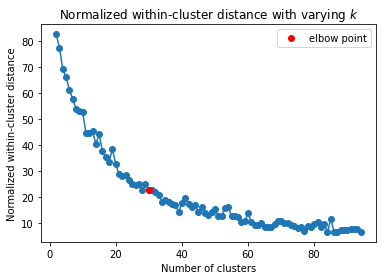

In [127]:
# Plot the distances and the elbow point
plt.plot(k_range, W_C_list, '-o')
# ith entry in diff_W_C is the gap between ith and i+1th entry in k_range
plt.plot(k_range[stop_point], W_C_list[stop_point], 'ro', label = 'elbow point') 
plt.xlabel('Number of clusters')
plt.ylabel('Normalized within-cluster distance')
plt.title(fr'Normalized within-cluster distance with varying $k$')
plt.legend()
plt.show()

Obtain the clustering corresponding to this $k$ and provide an interpretation of such clusters.

In [128]:
# obtain the clustering corresponding to this k
np.random.seed(1223)
centroids_appropriate, labels_appropriate = k_mean_clustering(T, stop_point + 2, max_iter = 50, show = False)

Since T is the matrix of normalized eigenvectors corresponding to zero eigenvalues, the clusters obtained are based on the connectivity patterns between genes. Each cluster represents a group of genes that share a similar connectivity pattern to other genes in the network.

2.2.5

Identify the biggest cluster in 2.2.4.

In [102]:
# identify the biggest cluster
cluster_sizes = np.bincount(labels_appropriate)
biggest_cluster_label = np.argmax(cluster_sizes)

print("The biggest cluster label is:", biggest_cluster_label)
print("The size of the biggest cluster is:", cluster_sizes[biggest_cluster_label])

The biggest cluster label is: 17
The size of the biggest cluster is: 11


In [103]:
# identify the biggest cluster
biggest_cluster_mask = labels_appropriate == biggest_cluster_label
T_biggest = T[biggest_cluster_mask, :]

Find the normalised Laplacian of the subgraph. 

In [104]:
# find the normalised Laplacian of the biggest cluster
# use distance matrix as similar matrix
distance_matrix_biggest = cdist(T_biggest, T_biggest, 'euclidean')

# compute the exponential of each negative matrix element
A_biggest = np.exp(- distance_matrix_biggest)

# fill the diagonal with zeros
np.fill_diagonal(A_biggest, 0)

# set all edges below weight=0.3 to zero
A_biggest[A_biggest < 0.3] = 0

# define diagonal matrix of node degrees
weighted_degree_biggest = A_biggest.sum(axis=1) 

# computing inverse square root vector of degree
weighted_degree_sqrt_biggest = 1.0 / np.sqrt(weighted_degree_biggest)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt_biggest = np.diag(weighted_degree_sqrt_biggest)

# define the normalised Laplacian
L_norm_biggest = np.eye(A_biggest.shape[0]) - D_inv_sqrt_biggest.dot(A_biggest.dot(D_inv_sqrt_biggest))

Use the normalised Laplacian to perform spectral partitioning and derive a binary partition of the subgraph corresponding to this cluster. 

In [105]:
# return the smallest magnitude eigenvectors and eigenvalues
eigenvals_biggest, eigenvecs_biggest = linalg.eigsh(L_norm_biggest, 2, which="SM", return_eigenvectors=True)

# printing the eigenvalues
print(fr'The first eigenvalue is: {eigenvals_biggest[0]}.')
print(fr'The second eigenvalue is: {eigenvals_biggest[1]}.')

# extract the second eigenvector
second_eigenvector_biggest = eigenvecs_biggest[:,1]

The first eigenvalue is: 9.249483214543508e-17.
The second eigenvalue is: 1.0080587627696842.


In [106]:
# define a partition and binarize the negative and positive eigenvector values
spectral_partition_biggest = second_eigenvector_biggest
spectral_partition_biggest[spectral_partition_biggest < 0] = 0
spectral_partition_biggest[spectral_partition_biggest > 0] = 1

In [107]:
print(fr'The binary partition of the biggest cluster is: {spectral_partition_biggest}')

The binary partition of the biggest cluster is: [0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.]


Design a plot to visualise the magnitude of the network links within each partition and across the two partitions.

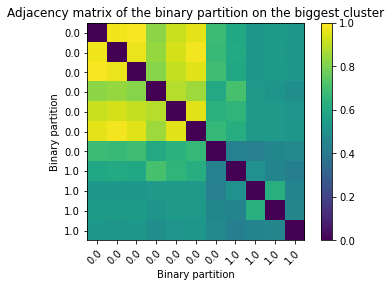

In [108]:
# sort the rows and columns by partition membership
perm = np.argsort(spectral_partition_biggest)
A_biggest_perm = A_biggest[perm, :][:, perm]
spectral_partition_biggest_perm = spectral_partition_biggest[perm]

# plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(A_biggest_perm, vmin=0, vmax=1)
ax.set_xticks(np.arange(11))
ax.set_yticks(np.arange(11))
ax.set_xticklabels(spectral_partition_biggest_perm)
ax.set_yticklabels(spectral_partition_biggest_perm)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im)
plt.title('Adjacency matrix of the binary partition on the biggest cluster')
plt.xlabel('Binary partition')
plt.ylabel('Binary partition')
plt.show()

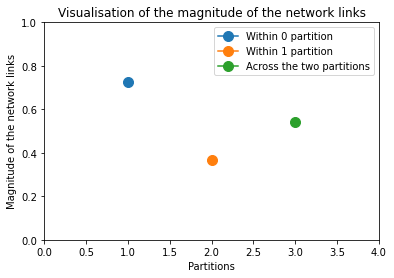

In [129]:
# calculate magnitude of links 
d1 = np.mean(A_biggest[spectral_partition_biggest == 0, :][:, spectral_partition_biggest == 0]) # within 0 partition
d2 = np.mean(A_biggest[spectral_partition_biggest == 1, :][:, spectral_partition_biggest == 1]) # within 1 partition
d3 = np.mean(A_biggest[spectral_partition_biggest == 0, :][:, spectral_partition_biggest == 1]) # across the two partitions

# visualisation
plt.xlim(0, 4)
plt.ylim(0, 1)
plt.plot(1, d1, marker="o", markersize = 10, label = 'Within 0 partition')
plt.plot(2, d2, marker="o", markersize = 10, label = 'Within 1 partition')
plt.plot(3, d3, marker="o", markersize = 10, label = 'Across the two partitions')
plt.title('Visualisation of the magnitude of the network links')
plt.xlabel('Partitions')
plt.ylabel('Magnitude of the network links')
plt.legend()
plt.show()

From the plot we can see that the links within one partition $0$ are generally stronger than the links within the other partition $1$, which indicates that there is a stronger connectivity within one partition than the other. 

The magnitude of links within cluster $0$ is higher than the magnitude of links across the two partitions.

2.2.6

Consider the subgraph from 2.2.5, compute the degree centrality of the nodes in this subgraph and print the index of 5 top-ranking ones. 

In [120]:
# compute the degree centrality
degree_centrality_biggest = weighted_degree_biggest / np.sum(weighted_degree_biggest)

# sort the genes in descending order by degree centrality
sorted_genes_biggest = np.argsort(degree_centrality_biggest)[::-1]

# print the index of the top 5 ranking genes
print(fr'The index of the 5 top ranking genes for the sub graph is: {sorted_genes_biggest[:5]}')

The index of the 5 top ranking genes for the sub graph is: [1 9 0 3 8]


Compare the degree centrality values with the ones obtained for the full graph in 2.2.2, and explain the results of this comparison.

In [121]:
# print the degree centrality values
print(fr'The values of the 5 top ranking genes for the full graph is: {degree_centrality[sorted_genes[:5]]}')
print(fr'The values of the 5 top ranking genes for the sub graph is: {degree_centrality_biggest[sorted_genes_biggest[:5]]}')

The values of the 5 top ranking genes for the full graph is: [0.02687344 0.02593545 0.02537837 0.02523066 0.02487023]
The values of the 5 top ranking genes for the sub graph is: [0.10604279 0.10597582 0.1055435  0.105061   0.10459443]


The values of the 5 top ranking genes for the sub graph is larger than that for the full graph, which indicates that these genes may play a more important role in the sub graph than in the larger graph.

The sub graph is the largest cluster by k-means method, by the higher degree centrality, the sub graph may be a highly connected subset of the full graph.